In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json

import sys
sys.path.append('..')
from helper.orderbook_trader import OrderbookTradingSimulator
from helper.manage_orderbooks_v2 import OrderbookEpisodesGenerator
from helper.Q_learning import QLearn, state_as_string, round_custombase

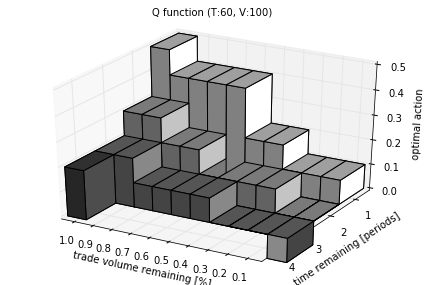

Length of episodes_train: 541
Length of episodes_test: 743
Length of episodes_test_BTCETH: 541


In [131]:
ql = QLearn(actions=list(np.linspace(-0.4, 1.0, num=15)), vol_intervals=10)
ql = ql.load("../pickles/Q_table_30samples.json")
ql.plot_Q()

T = ql.T
V = ql.V
decisionfrequency = ql.decisionfrequency
actions = ql.actions

filename = '../../data/obs_2016-11_USDT_BTC_range1.2.dict'
filename_test = '../../data/obs_2016-12_USDT_BTC_range1.2.dict'

episodes_train = OrderbookEpisodesGenerator(filename=filename, episode_length=T*decisionfrequency)
print("Length of episodes_train: {}".format(len(episodes_train)))

episodes_test = OrderbookEpisodesGenerator(filename=filename_test, episode_length=T*decisionfrequency)
print("Length of episodes_test: {}".format(len(episodes_test)))

filenameBTCETH = '../../data/obs_2016-11_BTC_ETH_range1.2.dict'
episodes_test_BTCETH = OrderbookEpisodesGenerator(filename=filenameBTCETH, episode_length=T*decisionfrequency)
print("Length of episodes_test_BTCETH: {}".format(len(episodes_test_BTCETH)))

In [150]:
def run_Q(V, H, T, ql, episode_windows, actions):
    costs = pd.DataFrame([])
    decisionfrequency = int(H/T)

    for episode in tqdm(episode_windows):
        index = episode[0].timestamp
        
        volume = V
        
        ## Learned strategy
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=T,
                                        decisionfrequency=decisionfrequency)
        for tt in range(1, T+1, 1)[::-1]:
            new_vol = round_custombase(ots.volume, base=ql.vol_intervals)  

            if new_vol > 0:
                state = state_as_string(time_left=tt, volume_left=new_vol/V)

                action = ql.chooseAction(state)

                # print(state, action)
                obs = episode[decisionfrequency * (T-tt)].copy()
                # obs = [elem.copy() for elem in obs_]
            
                ask = obs.get_ask()
                # center = ots.masterbook.get_center()
                limit = ask * (1. + (action/100.))
            else:
                # theoreticall done
                limit == None
            ots.trade(limit = limit, extrainfo={'ACTION':action})
        costs.loc[index, 'Learned'] = ots.history.cost.sum()
        
        for a in actions:
            lim = episode[0].get_ask() * (1. + (a/100.))
            # print("\n### Fixed limit at: {} (ASK+4) ###".format(lim))
            ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=1,
                                            decisionfrequency=decisionfrequency*T)
            ots.trade(limit = lim)
            key = 'ask*{:1.3f}'.format((1. + (a/100.)))
            costs.loc[index, key] = ots.history.cost.sum()
        
        ## market order
        ots = OrderbookTradingSimulator(orderbooks=episode, volume=volume, tradingperiods=T,
                                        decisionfrequency=decisionfrequency)
        ots.trade(limit = None)
        costs.loc[index, 'Market'] = ots.history.cost.sum()
        
    return costs

In [151]:

print("T={}, decisionfrequency={}".format(T, decisionfrequency))
costs_list_train = run_Q(V=100, H=T*decisionfrequency, T=T, ql=ql, episode_windows = episodes_train[:3], actions=actions)

T=4, decisionfrequency=15



  0%|          | 0/3 [00:00<?, ?it/s]
Exception in thread Thread-20:
Traceback (most recent call last):
  File "/Users/axelperschmann/anaconda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/axelperschmann/anaconda/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/axelperschmann/anaconda/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 3/3 [00:29<00:00,  9.56s/it]


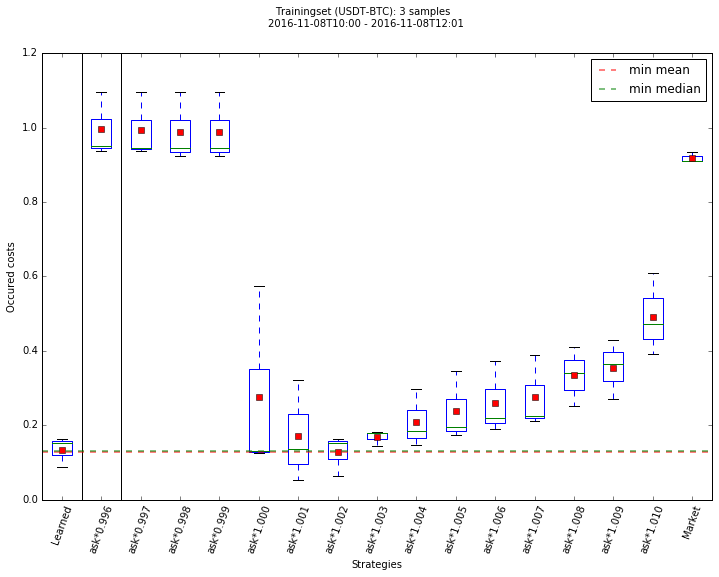

In [165]:
def plot_experiment_results(experiments, name=None):
    experiments.plot.box(showmeans=True, color={'medians': 'green'}, figsize=(12, 8), showfliers=False)
    plt.axvline(1.5, color='black')
    plt.axvline(2.5, color='black')
    plt.axhline(0, color='black')
    plt.axhline(experiments.mean().min(), color='red', alpha=0.5, linewidth=2, linestyle='--', label='min mean')
    plt.axhline(experiments.median().min(), color='green', alpha=0.5, linewidth=2, linestyle='--', label='min median')
    
    title = "{} samples  \n{} - {}".format(len(experiments), experiments.index[0], experiments.index[-1])
    if name is not None:
        title = "{}: {}".format(name, title)
    plt.suptitle(title)
    plt.xlabel("Strategies")
    plt.ylabel("Occured costs")
    plt.savefig("boxplot_train.pdf")
    plt.xticks(rotation=70)
    # plt.ylim((0.2, 0.4))    
    plt.legend(loc='best')
    plt.show()

# experiments = pd.DataFrame(costs_list_train)
plot_experiment_results(costs_list_train, name='Trainingset (USDT-BTC)')

In [167]:
costs_list_test = run_Q(V=100, H=T*decisionfrequency, T=T, ql=ql, episode_windows = episodes_test[0:30], actions=actions)

100%|██████████| 30/30 [07:01<00:00, 12.32s/it]


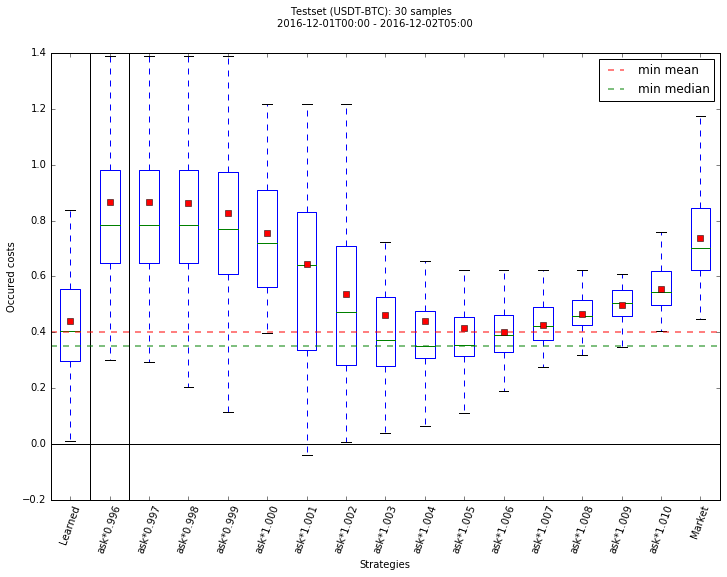

In [168]:
plot_experiment_results(costs_list_test, name='Testset (USDT-BTC)')

In [ ]:
print("Length of episodes_test: {}".format(len(episodes_test)))

In [132]:
costs_list_test_BTCETH = run_Q(V=100, H=T*decisionfrequency, T=T, ql=ql, episode_windows = episodes_test_BTCETH[0:30], actions=actions)

100%|██████████| 30/30 [01:49<00:00,  3.58s/it]


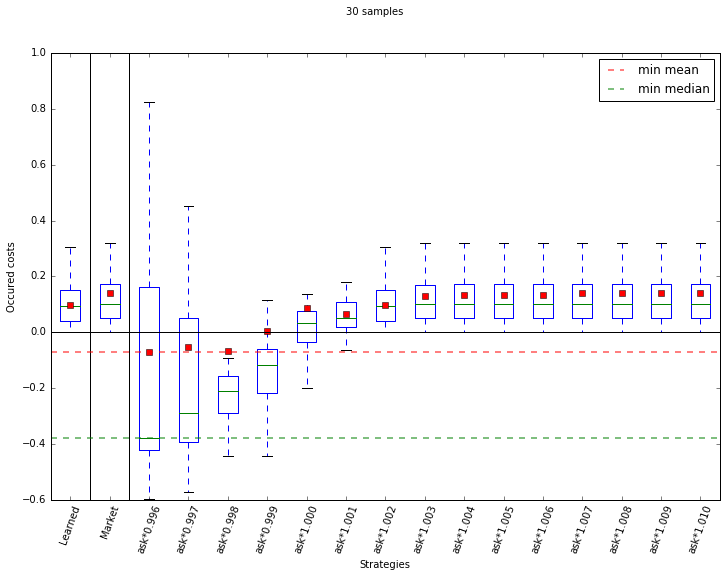

In [134]:
experiments = pd.DataFrame(costs_list_test_BTCETH)
plot_experiment_results(costs_list_test_BTCETH, name='Testset (BTC-ETH)')